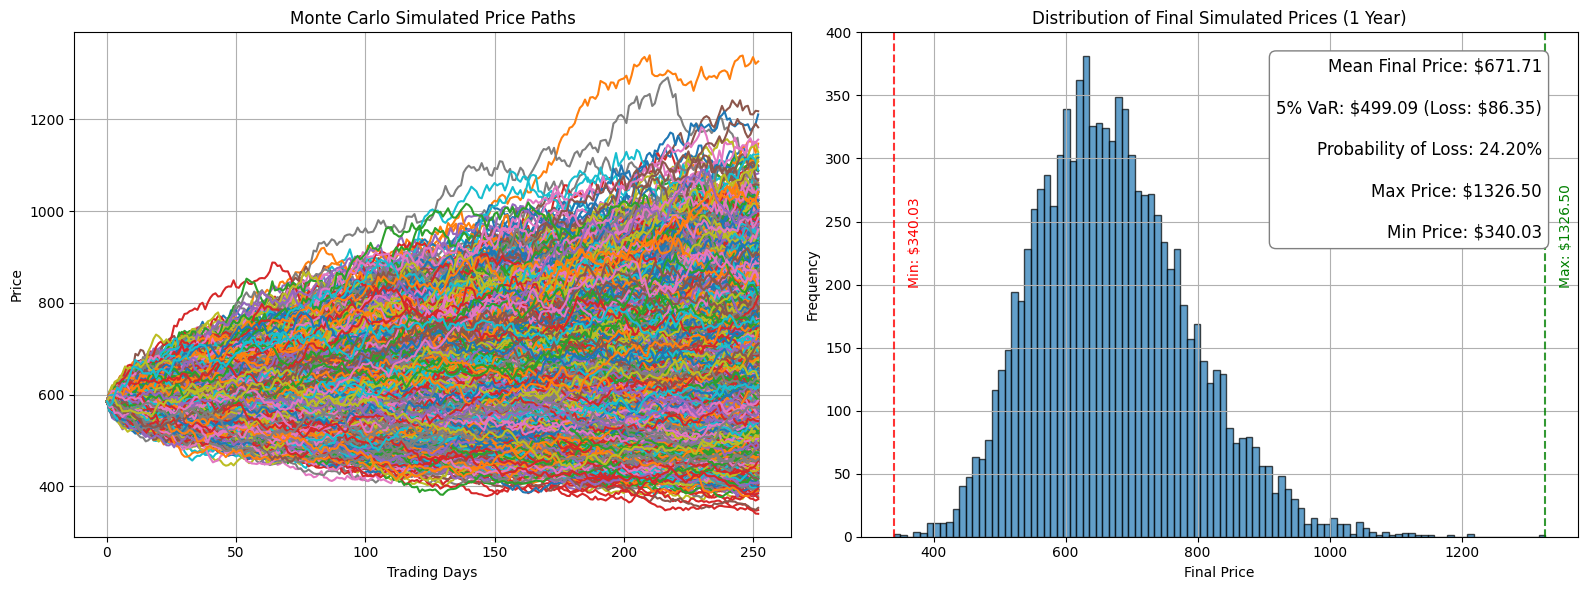

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

ticker_symbol = "VOO"
ticker = yf.Ticker(ticker_symbol)
historical = ticker.history(period="max")
prices = historical['Close']

# compute daily logarithmic returns and annualize
log_returns = np.log(prices / prices.shift(1)).dropna()

# annualize the mean and volatility
trading_days = 252
mu = log_returns.mean() * trading_days
sigma = log_returns.std() * np.sqrt(trading_days)

# starting price for the simulation (the last close price)
S0 = prices.iloc[-1]

# monte carlo parameters
T  = 1
N  = trading_days
dt = T / N
M  = 10000

# pre-allocate paths and draw shocks
price_paths = np.zeros((M, N+1))    # pre-allocate the array for the simulated prices
price_paths[:, 0] = S0  # set the starting price
Z = np.random.normal(size=(M, N))   # drawing random numbers from a normal distribution

# simulate gbm across all paths - price_paths[:, t] creates the vector of prices at time t for each path
for t in range(1, N+1):
    price_paths[:, t] = price_paths[:, t-1] * np.exp(
        (mu - 0.5 * sigma**2) * dt
        + sigma * np.sqrt(dt) * Z[:, t-1]
    )

# extract the final prices from the last column of the price_paths array
final_prices = price_paths[:, -1] 

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plot sample price paths in the first subplot
for i in range(M):
    axs[0].plot(price_paths[i])
axs[0].set_title("Monte Carlo Simulated Price Paths")
axs[0].set_xlabel("Trading Days")
axs[0].set_ylabel("Price")
axs[0].grid(True)

# Calculate max and min prices
max_price = np.max(final_prices)
min_price = np.min(final_prices)

# Plot histogram of final prices in the second subplot
axs[1].hist(final_prices, bins=100, edgecolor='black', alpha=0.7)
axs[1].set_title("Distribution of Final Simulated Prices (1 Year)")
axs[1].set_xlabel("Final Price")
axs[1].set_ylabel("Frequency")
axs[1].grid(True)

# Add vertical lines for max and min prices
axs[1].axvline(x=max_price, color='green', linestyle='--', alpha=0.8)
axs[1].axvline(x=min_price, color='red', linestyle='--', alpha=0.8)

mean_price = np.mean(final_prices)  # mean of the final prices
var_5      = np.percentile(final_prices, 5) # 5% VaR - the price at which 5% of the final prices are below
prob_loss  = np.mean(final_prices < S0) # probability that final price is less than starting price (S0)

# Add text box with metrics
risk_text = (
    f"Mean Final Price: ${mean_price:.2f}\n\n"
    f"5% VaR: ${var_5:.2f} (Loss: \\${S0 - var_5:.2f})\n\n"
    f"Probability of Loss: {prob_loss:.2%}\n\n"
    f"Max Price: ${max_price:.2f}\n\n"
    f"Min Price: ${min_price:.2f}"
)

# place the box in the upper right of the histogram subplot
plt.sca(axs[1])
plt.text(
    0.95, 0.95, risk_text,
    transform=axs[1].transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='right',
    bbox=dict(boxstyle="round,pad=0.4", facecolor='white', edgecolor='gray')
)

# Add annotations for max and min prices
ymin, ymax = axs[1].get_ylim()
axs[1].annotate(f'Max: ${max_price:.2f}', 
                xy=(max_price, ymax*0.5),
                xytext=(10, 0),
                textcoords='offset points',
                color='green',
                rotation=90)
axs[1].annotate(f'Min: ${min_price:.2f}', 
                xy=(min_price, ymax*0.5),
                xytext=(10, 0),
                textcoords='offset points',
                color='red',
                rotation=90)

plt.tight_layout()
plt.show()
